# Week 9: Clustering of Masaeli et al.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mat = pd.read_csv('WBC.csv')
mat.drop('Unnamed: 0', axis=1, inplace=True)

#### (1) Choose any two variables and plot them against cell identity (in color). Do you see clear separation of these classes? What does this tell you about whether or not you can classify the cells if differing type?

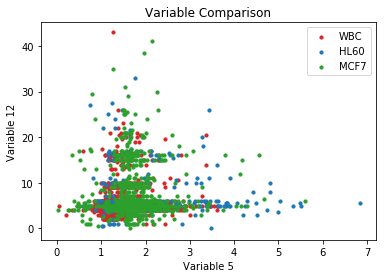

In [2]:
cellData = mat.copy()

cellData.drop('Sample', axis = 1, inplace = True)

WBC_data = cellData[mat['Sample'] == 'WBC']
HL60_data = cellData[mat['Sample'] == 'HL60']
MCF7_data = cellData[mat['Sample'] == 'MCF7']

plt.subplots()
plt.scatter(WBC_data['V5'], WBC_data['V12'], color = 'tab:red', s = 10, label = 'WBC')
plt.scatter(HL60_data['V5'], HL60_data['V12'], color = 'tab:blue', s = 10, label = 'HL60')
plt.scatter(MCF7_data['V5'], MCF7_data['V12'], color = 'tab:green', s = 10, label = 'MCF7')
plt.xlabel('Variable 5')
plt.ylabel('Variable 12')
plt.title('Variable Comparison')
plt.legend();

There is no broad overlap between the three cell types with regard to variable 12 and 5. I cannot discern cell type based on these variables. This tells me that looking at individual variables alone is not enough to distinguish the cells.

#### (2) Use principal components analysis to visualize the variation in each variable. Plot the first two principal components against the cell type. Do you see better separation in this case? What does this tell you about your ability to distinguish the cell types?

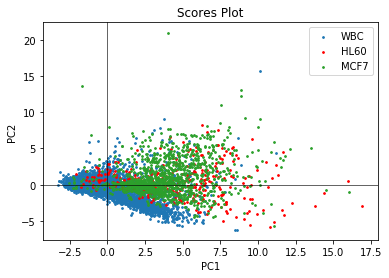

In [3]:
from sklearn.decomposition import PCA
from scipy.stats import zscore
X = cellData.values
Xnorm = zscore(X)

WBC_ = WBC_data.values
HL60_ = HL60_data.values
MCF7_ = MCF7_data.values
X_PCA = PCA(n_components = 2)
Scores = X_PCA.fit_transform(Xnorm)

plt.scatter(Scores[0:8628,0], Scores[0:8628,1], s = 3, color = 'tab:blue', label = 'WBC');
plt.scatter(Scores[8629:8950,0], Scores[8629:8950,1], s = 3, color = 'red', label = 'HL60');
plt.scatter(Scores[8950:10107,0], Scores[8950:10107,1], s = 3, color = 'tab:green', label = 'MCF7');

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6); # include line y = 0
plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6); # include line x = 0
plt.legend()
plt.title('Scores Plot')
plt.xlabel('PC1')
plt.ylabel('PC2');

I cannot distinguish HL60 cells from MCF7 cells. White blood cells are more negatively located along PC1 than HL60 or MCF7, but there is overlap which makes it diffuclt to be confident with any given classification based on principle components alone.

#### (3) How does partial least squares fare in desciminating cancer and non-cancer cells (make cancer=1 and non-cancer=0; this is called PLS-DA)? How does this relate to the results in the previous questions?

In [4]:
from sklearn.cross_decomposition import PLSRegression

# Generate Y vector
Y = np.ones(len(cellData))
Y[0:8629] = 0

#  Generate predictions from PLSR
plsr = PLSRegression(n_components = 2)
plsr.fit_transform(Xnorm, Y)
prediction3 = plsr.predict(Xnorm)

def Evaluate_Pred(prediction, Y, prin = True):
    pred_threshold = np.round(np.abs(prediction)) # round each value to 0 or 1

    # Count correct predictions
    count = 0
    for i in range(len(Y)):
        if pred_threshold[i] == Y[i]:
            count += 1
    perc_predict = count/len(Y)*100
    if prin is True:
        print('%.2f%% Accuracy' %perc_predict)
    else:
        return perc_predict

print('PLS-DA Prediction')
Evaluate_Pred(prediction3, Y)

PLS-DA Prediction
95.52% Accuracy


PLS-DA is able to predict the cell's state at 95% accuracy. Plotting the variables alone does not show a clear difference, and plotting just principle components shows more separation between groups, but is still not extremely clear. Despite this, PLS-DA is able to accurately predict cell state.

#### (4) Setup a support vector machine classifier (with linear kernel) to distinguish cancer and non-cancer.

Evaluate how well this performs (hint: think carefully about how you evaluate the model).

In [5]:
from sklearn.svm import SVC
def Fun_SVC(Xf, Yf, kernel, gamma = 'auto_deprecated', degree = 3, prin = True):
    Xnorm = zscore(Xf)
    svc4 = SVC(kernel = kernel, gamma = gamma, degree = degree)
    svc4.fit(Xnorm, Yf)
    prediction4 = svc4.predict(Xnorm)

    if prin is True:
        print(f'SVM ({kernel} kernel) Prediction')
        Evaluate_Pred(prediction4, Yf, prin = prin)
    elif prin is False:
        return Evaluate_Pred(prediction4, Yf, prin = prin)
    
Fun_SVC(X, Y, 'linear')

SVM (linear kernel) Prediction
97.08% Accuracy


The SVM model slightly outperforms the PLSR model. This makes sense as SVM models tend to have better prediction accuracy but lower explanability than PLSR. We cannot easily visualize the SVM model with principle components like PLSR, but it has a prediction advantage.

#### (5) Choose and justify your selection of a different kernel to use in SVM classification. (Hint: It should be a kernel with varying complexity, such as polynomial or RBF.)

In [6]:
Fun_SVC(X, Y, 'rbf')
print('\n')
Fun_SVC(X, Y, 'poly')

SVM (rbf kernel) Prediction
98.19% Accuracy


SVM (poly kernel) Prediction
98.10% Accuracy


Using a kernel with varying complexity slightly improves the accuracy over a linear model. The non-linear models are able to fit the data better, but this could with a consequence of overfitting.

#### (6) Vary the complexity of your kernel and evaluate the ability of it to descriminate data both directly and on crossvalidation.

How does the answer of which classification strategy vary based on whether you are performing cross-validation?

In [7]:
def Plt_Pred_Acc(Pred, numDeg):
    plt.scatter(range(1,numDeg+1), Pred, color = 'k')
    plt.xlabel('Number of Degrees')
    plt.ylabel('Prediction Accuracy')

In [8]:
maxDeg = 8
direct_pred = np.zeros(maxDeg)

for i, deg in enumerate(range(1,maxDeg+1)):
    direct_pred[i] = Fun_SVC(X, Y, 'poly', degree = deg, prin = False)

Average prediction accuracy: 97.72%
Max prediction accuracy: 98.20%


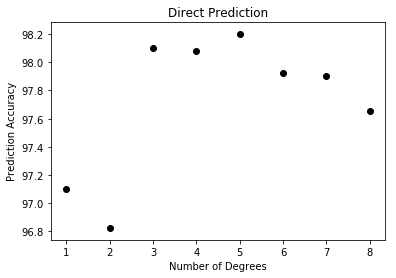

In [9]:
plt.title('Direct Prediction')
Plt_Pred_Acc(direct_pred, maxDeg)
Direct_avg = np.mean(direct_pred)
print('Average prediction accuracy: %.2f%%' %Direct_avg)
print('Max prediction accuracy: %.2f%%' %max(direct_pred))

In [11]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import KFold
import time

StanScale = StandardScaler()

def kfold_CV(Xf, Yf, deg, raw = False):
    kfold = KFold(n_splits = 10, shuffle = True)
    YpredictLOO = np.zeros(len(Yf))
    svc6 = SVC(kernel = 'poly', degree = deg)

    for train, test in kfold.split(Xf, Yf):
        #print(np.shape(train))
        XTrain = Xf[train, :]
        YTrain = Yf[train]
        XTrainNorm = StanScale.fit_transform(XTrain)
        svc6.fit(XTrainNorm, YTrain)
        Xtest = X[test, :]#.reshape(-1,1))
        #print(Xtest.shape)
        #print(YpredictLOO[test])
        YpredictLOO[test] = svc6.predict(StanScale.transform(Xtest))
    if raw is False:
        return Evaluate_Pred(YpredictLOO, Yf, prin = False)
    elif raw is True:
        return YpredictLOO

In [12]:
runCV = True # This code takes a few minutes
if runCV is True:
    maxDeg = 8
    CV_pred = np.zeros(maxDeg)

    t = time.time()

    for i, deg in enumerate(range(1,maxDeg+1)):
        CV_pred[i] = kfold_CV(X, Y, deg)

    elapsed = time.time() - t
    print('%f seconds elapsed' %elapsed)
    #np.save('SVC_poly_varyDeg_CV.npy', CV_pred)

108.872679 seconds elapsed


Average prediction accuracy: 96.12%
Max prediction accuracy: 98.20%


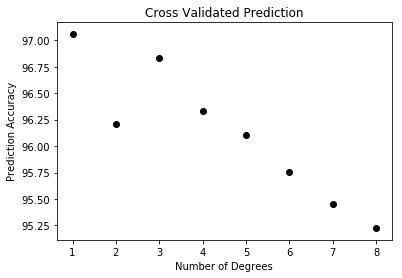

In [13]:
CV_pred = np.load('SVC_poly_varyDeg_CV.npy')
plt.title('Cross Validated Prediction')
Plt_Pred_Acc(CV_pred, maxDeg)
CV_avg = np.mean(CV_pred)
print('Average prediction accuracy: %.2f%%' %CV_avg)
print('Max prediction accuracy: %.2f%%' %max(direct_pred))

While the maximum prediction accuracy for the direct and cross validated predictions, the average prediction accuracy for the cross validated model is lower than that of the direct model. This conforms with expectations that cross validation should make prediction slightly worse. Additionally, the fitting error must be lower than the prediction error.

#### (7) Your experimental collaborator asks you to determine whether she can collect a fewer number of measurements (cells) and still obtain the same classification efficiency when building a new estimator. How might you determine this? Can she?

To determine this, we could just remove cell observations from our dataset and see how the new set predicts.
At the very least, we need one of each type of cell. If the ratio of cell number of each population is important, then we can just remove cells at that given ratio.

#### (8) What if you can change the numbers of individual cell types that you collect? Is the model you obtain sensitive to the number of cells in each group to the same extent? Try this with one cell population.

In [14]:
# Try droping cells from MCF7 cell population
# indices 8950:10107
Ypd = pd.DataFrame(data = Y)

trials = 10

drops = np.round(np.logspace(0,3, num = trials))
Drop_pred_MCF7 = np.zeros(trials)

for i, numDrops in enumerate(drops):
    cellData_ = cellData.drop(labels = np.linspace(9000, 8999 + numDrops, num = numDrops))
    Ypd_ = Ypd.drop(labels = np.linspace(9000, 8999 + numDrops, num = numDrops))

    Xdrop = cellData_.values
    Ydrop = np.squeeze(Ypd_.values)

    XTrainNorm = StanScale.fit_transform(Xdrop)
    svc8 = SVC(kernel = 'poly', degree = 1)
    svc8.fit(XTrainNorm, Ydrop)

    Predict_drop = np.zeros(len(Y))

    for j in range(len(Y)):
        Xeval = (X[j, :]).reshape(1,-1)
        Predict_drop[j] = svc8.predict(StanScale.transform(Xeval))

    Drop_pred_MCF7[i] = Evaluate_Pred(Predict_drop, Y, prin = False)
print(Drop_pred_MCF7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely int

[97.1013059  97.1013059  97.11119905 97.1210922  97.1210922  97.1013059
 97.11119905 97.14087851 96.93312228 96.39889197]


Number of dropped MCF7 cells: [   1.    2.    5.   10.   22.   46.  100.  215.  464. 1000.]


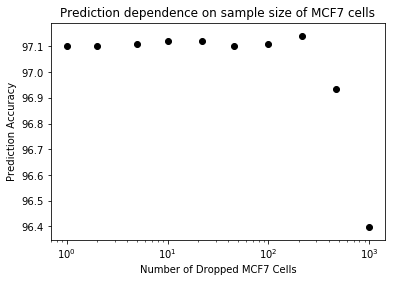

In [20]:
plt.xscale('log')
plt.scatter(drops, Drop_pred_MCF7, color = 'k')
plt.title('Prediction dependence on sample size of MCF7 cells')
plt.xlabel('Number of Dropped MCF7 Cells')
plt.ylabel('Prediction Accuracy');
print(f'Number of dropped MCF7 cells: {drops}');

In [16]:
#Drop WBC
Ypd = pd.DataFrame(data = Y)

trials = 10

drops = np.round(np.logspace(0,3, num = trials))
Drop_pred_WBC = np.zeros(trials)

for i, numDrops in enumerate(7*drops):
    cellData_ = cellData.drop(labels = np.linspace(1, 0 + numDrops, num = numDrops))
    Ypd_ = Ypd.drop(labels = np.linspace(1, 0 + numDrops, num = numDrops))

    Xdrop = cellData_.values
    Ydrop = np.squeeze(Ypd_.values)

    XTrainNorm = StanScale.fit_transform(Xdrop)
    svc8 = SVC(kernel = 'poly', degree = 1)
    svc8.fit(XTrainNorm, Ydrop)

    Predict_drop = np.zeros(len(Y))

    for j in range(len(Y)):
        Xeval = (X[j, :]).reshape(1,-1)
        Predict_drop[j] = svc8.predict(StanScale.transform(Xeval))

    Drop_pred_WBC[i] = Evaluate_Pred(Predict_drop, Y, prin = False)
print(Drop_pred_WBC)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning:

[97.11119905 97.1013059  97.1013059  97.09141274 97.09141274 97.09141274
 97.1013059  97.06173328 96.54728928 46.54728928]


Number of dropped WBC cells: [   7.   14.   35.   70.  154.  322.  700. 1505. 3248. 7000.]


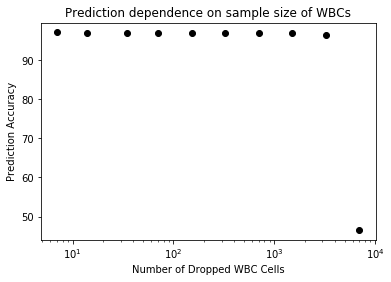

In [17]:
plt.xscale('log')
plt.scatter(7*drops, Drop_pred_WBC, color = 'k')
plt.title('Prediction dependence on sample size of WBCs')
plt.xlabel('Number of Dropped WBC Cells')
plt.ylabel('Prediction Accuracy');
print(f'Number of dropped WBC cells: {7*drops}')

I droped MCF7 cells from the model-building process and then used this model to predict the entire dataset. The prediction accuracy was still very high around 97.1%, only dropping to 96.4% when dropping 1000 cells. This indicates that the model is not very sensitive to the number of measurements. I repeated this process with WBC, dropping up to 7000 measurements. At 7000 dropped measurements, the prediction accuracy drops to below 50%. This demonstrates that there is some thershold sample number required to achieve good prediction.

#### (9) Your collaborator collects completely new data and brings it to you for classification. You take your chosen optimal model from (7) and classify each cell. Would you expect your model to perform better, identically, or worse than before? Why?

I expect my model to perform worse than before because the cells are not from the same population as the cells I built the model on. Those cells were cultured by different people in different BSC's, measured in different machines, etc. Though the populations could be similar if the culturing and data collection methods were similar, there are inevitable, uncontrollable differences between populations.

#### (10) As a prior distribution, assume that, among patients coming in for testing, 99% are cancer-free in the end. Estimate how well your assay needs to perform to confidently identify cancer patients.

In [18]:
prediction = kfold_CV(X, Y, 1, raw = True)

pred_threshold = np.round(np.abs(prediction)) # round each value to 0 or 1
#print(pred_threshold)
numPos = np.sum(pred_threshold)
totalNum = len(pred_threshold)
p_testPos = numPos/totalNum

p_testneg = 1- p_testPos

In [19]:
print('P(test pos): %.2f%%' %(p_testPos*100))
numPos = np.sum(Y)
totalNum = len(Y)
p_Pos = numPos/totalNum
p_neg = 1 - p_Pos
print('P(being pos) [from dataset]: %.2f%%' %(p_Pos*100))

# Count correct predictions
countPos = 0
countNeg = 0
for i in range(len(Y)):
    if Y[i] == 1:
        if pred_threshold[i] == 1:
            countPos += 1
    elif Y[i] == 0:
        if pred_threshold[i] == 0:
            countNeg += 1
            
num_pos = np.sum(Y)
p_testPos_givenPos = countPos/num_pos
num_neg = len(Y) - num_pos
p_testneg_givenneg = countNeg/num_neg

print('P(test pos | cell is pos): %.2f%%' %(p_testPos_givenPos*100))
print('P(test neg | cell is neg): %.2f%%\n' %(p_testneg_givenneg*100))

# Calculate probability of being + given + test from dataset
p_pos_givenTestPos = p_Pos*p_testPos_givenPos/p_testPos # apply Bayes law to get true positives
p_neg_givenTestneg = p_neg*p_testneg_givenneg/p_testneg # apply Bayes law to get true negatives
print('Based on P(being pos) from dataset (14.63%)')
print('P(being pos | pos test): %.2f%%' %(p_pos_givenTestPos*100))
print('P(being neg | neg test): %.2f%%\n' %(p_neg_givenTestneg*100))

# Calculate probability of being + given + test with prior
p_Pos = 0.01
p_neg = 1 - p_Pos
p_pos_givenTestPos = p_Pos*p_testPos_givenPos/p_testPos # apply Bayes law to get true positives
p_neg_givenTestneg = p_neg*p_testneg_givenneg/p_testneg # apply Bayes law to get true positives
print('Based on P(being pos) with prior that 99% of those tested are cancer-free')
print('P(being pos | pos test): %.2f%%' %(p_pos_givenTestPos*100))
#print('P(being neg | neg test): %.2f%%' %(p_neg_givenTestneg*100))

P(test pos): 13.32%
P(being pos) [from dataset]: 14.63%
P(test pos | cell is pos): 85.46%
P(test neg | cell is neg): 99.05%

Based on P(being pos) from dataset (14.63%)
P(being pos | pos test): 93.91%
P(being neg | neg test): 97.55%

Based on P(being pos) with prior that 99% of those tested are cancer-free
P(being pos | pos test): 6.42%


Using the probability of being positive from the dataset, which is 14.63%, the probability of being positive given a positive test is almost 94%. This is a very good test given these conditions. When using the prior that 99% of those tested are cancer-free, the probability of being positive given a positive test drops to 6.4%. This exemplifies the benefits of limiting a test to a high-risk subpopulation to increase its percent of true positives.
To achieve a 95% probability of being positive given a positive test assuming that 1% of the population tested has cancer, we could modify the model to rarely predict a positive test, reducing the probability of positive tests in the denominator of the expression. We could also improve the probability of testing positive given that a cell is positive, but this value is already fairly high at 85%, so even if it were 100%, the probability of being positive given a positive test would be low.